## 2.6 Q学習で迷路を攻略

In [32]:
# 使用するパッケージの宣言
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


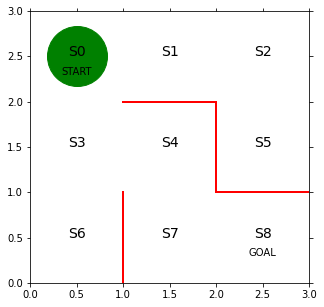

In [33]:
# 初期位置での迷路の様子

# 図を描く大きさと、図の変数名を宣言
fig = plt.figure(figsize=(5, 5))
ax = plt.gca()

# 赤い壁を描く
plt.plot([1, 1], [0, 1], color='red', linewidth=2)
plt.plot([1, 2], [2, 2], color='red', linewidth=2)
plt.plot([2, 2], [2, 1], color='red', linewidth=2)
plt.plot([2, 3], [1, 1], color='red', linewidth=2)

# 状態を示す文字S0～S8を描く
plt.text(0.5, 2.5, 'S0', size=14, ha='center')
plt.text(1.5, 2.5, 'S1', size=14, ha='center')
plt.text(2.5, 2.5, 'S2', size=14, ha='center')
plt.text(0.5, 1.5, 'S3', size=14, ha='center')
plt.text(1.5, 1.5, 'S4', size=14, ha='center')
plt.text(2.5, 1.5, 'S5', size=14, ha='center')
plt.text(0.5, 0.5, 'S6', size=14, ha='center')
plt.text(1.5, 0.5, 'S7', size=14, ha='center')
plt.text(2.5, 0.5, 'S8', size=14, ha='center')
plt.text(0.5, 2.3, 'START', ha='center')
plt.text(2.5, 0.3, 'GOAL', ha='center')

# 描画範囲の設定と目盛りを消す設定
ax.set_xlim(0, 3)
ax.set_ylim(0, 3)
plt.tick_params(axis='both', which='both', bottom='off', top='off',
                labelbottom='off', right='off', left='off', labelleft='off')

# 現在地S0に緑丸を描画する
line, = ax.plot([0.5], [2.5], marker="o", color='g', markersize=60)


In [34]:
# 初期の方策を決定するパラメータtheta_0を設定

# 行は状態0～7、列は移動方向で↑、→、↓、←を表す
theta_0 = np.array([[np.nan, 1, 1, np.nan],  # s0
                    [np.nan, 1, np.nan, 1],  # s1
                    [np.nan, np.nan, 1, 1],  # s2
                    [1, 1, 1, np.nan],  # s3
                    [np.nan, np.nan, 1, 1],  # s4
                    [1, np.nan, np.nan, np.nan],  # s5
                    [1, np.nan, np.nan, np.nan],  # s6
                    [1, 1, np.nan, np.nan],  # s7、※s8はゴールなので、方策はなし
                    ])


In [35]:
# 方策パラメータtheta_0をランダム方策piに変換する関数の定義


def simple_convert_into_pi_from_theta(theta):
    '''単純に割合を計算する'''

    [m, n] = theta.shape  # thetaの行列サイズを取得
    pi = np.zeros((m, n))
    for i in range(0, m):
        pi[i, :] = theta[i, :] / np.nansum(theta[i, :])  # 割合の計算

    pi = np.nan_to_num(pi)  # nanを0に変換

    return pi

# ランダム行動方策pi_0を求める
pi_0 = simple_convert_into_pi_from_theta(theta_0)


In [36]:
# 初期の行動価値関数Qを設定

[a, b] = theta_0.shape  # 行と列の数をa, bに格納
Q = np.random.rand(a, b) * theta_0 * 0.1
# *theta0をすることで要素ごとに掛け算をし、Qの壁方向の値がnanになる


In [37]:
# ε-greedy法を実装


def get_action(s, Q, epsilon, pi_0):
    direction = ["up", "right", "down", "left"]

    # 行動を決める
    if np.random.rand() < epsilon:
        # εの確率でランダムに動く
        next_direction = np.random.choice(direction, p=pi_0[s, :])
    else:
        # Qの最大値の行動を採用する
        next_direction = direction[np.nanargmax(Q[s, :])]

    # 行動をindexに
    if next_direction == "up":
        action = 0
    elif next_direction == "right":
        action = 1
    elif next_direction == "down":
        action = 2
    elif next_direction == "left":
        action = 3

    return action


def get_s_next(s, a, Q, epsilon, pi_0):
    direction = ["up", "right", "down", "left"]
    next_direction = direction[a]  # 行動aの方向

    # 行動から次の状態を決める
    if next_direction == "up":
        s_next = s - 3  # 上に移動するときは状態の数字が3小さくなる
    elif next_direction == "right":
        s_next = s + 1  # 右に移動するときは状態の数字が1大きくなる
    elif next_direction == "down":
        s_next = s + 3  # 下に移動するときは状態の数字が3大きくなる
    elif next_direction == "left":
        s_next = s - 1  # 左に移動するときは状態の数字が1小さくなる

    return s_next


In [38]:
# Q学習による行動価値関数Qの更新


def Q_learning(s, a, r, s_next, Q, eta, gamma):

    if s_next == 8:  # ゴールした場合
        Q[s, a] = Q[s, a] + eta * (r - Q[s, a])

    else:
        Q[s, a] = Q[s, a] + eta * (r + gamma * np.nanmax(Q[s_next,: ]) - Q[s, a])

    return Q

In [39]:
# Q学習で迷路を解く関数の定義、状態と行動の履歴および更新したQを出力


def goal_maze_ret_s_a_Q(Q, epsilon, eta, gamma, pi):
    s = 0  # スタート地点
    a = a_next = get_action(s, Q, epsilon, pi)  # 初期の行動
    s_a_history = [[0, np.nan]]  # エージェントの移動を記録するリスト

    while (1):  # ゴールするまでループ
        a = a_next  # 行動更新

        s_a_history[-1][1] = a
        # 現在の状態（つまり一番最後なのでindex=-1）に行動を代入

        s_next = get_s_next(s, a, Q, epsilon, pi)
        # 次の状態を格納

        s_a_history.append([s_next, np.nan])
        # 次の状態を代入。行動はまだ分からないのでnanにしておく

        # 報酬を与え,　次の行動を求めます
        if s_next == 8:
            r = 1  # ゴールにたどり着いたなら報酬を与える
            a_next = np.nan
        else:
            r = 0
            a_next = get_action(s_next, Q, epsilon, pi)
            # 次の行動a_nextを求めます。

        # 価値関数を更新
        Q = Q_learning(s, a, r, s_next, Q, eta, gamma)

        # 終了判定
        if s_next == 8:  # ゴール地点なら終了
            break
        else:
            s = s_next

    return [s_a_history, Q]


In [40]:
# Q学習で迷路を解く

eta = 0.1  # 学習率
gamma = 0.9  # 時間割引率
epsilon = 0.5  # ε-greedy法の初期値
v = np.nanmax(Q, axis=1)  # 状態ごとに価値の最大値を求める
is_continue = True
episode = 1

V = []  # エピソードごとの状態価値を格納する
V.append(np.nanmax(Q, axis=1))  # 状態ごとに行動価値の最大値を求める

while is_continue:  # is_continueがFalseになるまで繰り返す
    print("エピソード:" + str(episode))

    # ε-greedyの値を少しずつ小さくする
    epsilon = epsilon / 2

    # Q学習で迷路を解き、移動した履歴と更新したQを求める
    [s_a_history, Q] = goal_maze_ret_s_a_Q(Q, epsilon, eta, gamma, pi_0)

    # 状態価値の変化
    new_v = np.nanmax(Q, axis=1)  # 状態ごとに行動価値の最大値を求める
    print(np.sum(np.abs(new_v - v)))  # 状態価値関数の変化を出力
    v = new_v
    V.append(v)  # このエピソード終了時の状態価値関数を追加

    print("迷路を解くのにかかったステップ数は" + str(len(s_a_history) - 1) + "です")

    # 100エピソード繰り返す
    episode = episode + 1
    if episode > 100:
        break


エピソード:1
0.15462128000442907
迷路を解くのにかかったステップ数は102です
エピソード:2
0.19670321700398224
迷路を解くのにかかったステップ数は266です
エピソード:3
0.10698207779759852
迷路を解くのにかかったステップ数は52です
エピソード:4
0.12995923223216502
迷路を解くのにかかったステップ数は188です
エピソード:5
0.0932405494984242
迷路を解くのにかかったステップ数は12です
エピソード:6
0.09084067568276863
迷路を解くのにかかったステップ数は4です
エピソード:7
0.08987970029305808
迷路を解くのにかかったステップ数は4です
エピソード:8
0.08887592369513993
迷路を解くのにかかったステップ数は4です
エピソード:9
0.08782089664069284
迷路を解くのにかかったステップ数は4です
エピソード:10
0.0867068774872068
迷路を解くのにかかったステップ数は4です
エピソード:11
0.08552732341293026
迷路を解くのにかかったステップ数は4です
エピソード:12
0.08427718076660244
迷路を解くのにかかったステップ数は4です
エピソード:13
0.08295302343966468
迷路を解くのにかかったステップ数は4です
エピソード:14
0.08155307860985281
迷路を解くのにかかったステップ数は4です
エピソード:15
0.08007717130288938
迷路を解くのにかかったステップ数は4です
エピソード:16
0.078526612695611
迷路を解くのにかかったステップ数は4です
エピソード:17
0.07690405171972413
迷路を解くのにかかったステップ数は4です
エピソード:18
0.07521330513363879
迷路を解くのにかかったステップ数は4です
エピソード:19
0.07345917765181592
迷路を解くのにかかったステップ数は4です
エピソード:20
0.07164728082217797
迷路を解くのにかかったステップ数は4です
エピソード

In [41]:
# 状態価値の変化を可視化します
# 参考URL http://louistiao.me/posts/notebooks/embedding-matplotlib-animations-in-jupyter-notebooks/
from matplotlib import animation
from IPython.display import HTML
import matplotlib.cm as cm  # color map


def init():
    # 背景画像の初期化
    line.set_data([], [])
    return (line,)


def animate(i):
    # フレームごとの描画内容
    # 各マスに状態価値の大きさに基づく色付きの四角を描画
    line, = ax.plot([0.5], [2.5], marker="s",
                    color=cm.jet(V[i][0]), markersize=85)  # S0
    line, = ax.plot([1.5], [2.5], marker="s",
                    color=cm.jet(V[i][1]), markersize=85)  # S1
    line, = ax.plot([2.5], [2.5], marker="s",
                    color=cm.jet(V[i][2]), markersize=85)  # S2
    line, = ax.plot([0.5], [1.5], marker="s",
                    color=cm.jet(V[i][3]), markersize=85)  # S3
    line, = ax.plot([1.5], [1.5], marker="s",
                    color=cm.jet(V[i][4]), markersize=85)  # S4
    line, = ax.plot([2.5], [1.5], marker="s",
                    color=cm.jet(V[i][5]), markersize=85)  # S5
    line, = ax.plot([0.5], [0.5], marker="s",
                    color=cm.jet(V[i][6]), markersize=85)  # S6
    line, = ax.plot([1.5], [0.5], marker="s",
                    color=cm.jet(V[i][7]), markersize=85)  # S7
    line, = ax.plot([2.5], [0.5], marker="s",
                    color=cm.jet(1.0), markersize=85)  # S8
    return (line,)


#　初期化関数とフレームごとの描画関数を用いて動画を作成
anim = animation.FuncAnimation(
    fig, animate, init_func=init, frames=len(V), interval=200, repeat=False)

HTML(anim.to_jshtml())


limit_output extension: Maximum message size of 10000 exceeded with 1158218 characters